In [1]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import cv2

In [2]:
class Metrics:
    def __init__(self, y_true, y_pred):
        tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
        
        self.acc = metrics.accuracy_score(y_true, y_pred)
        self.sensitivity = tp = tp / (tp + fn)
        self.specificity = tn / (tn + fp)
        self.f1 = metrics.f1_score(y_true, y_pred)
        
    def __str__(self):
        return 'Acc: {:.5f}, sensitivity: {:.5f}, specificity: {:.5f}, F1-score: {:.5f}'.format(
            self.acc, self.sensitivity, self.specificity, self.f1)

In [3]:
DATA_PATH = 'data/'
X_IMG_PATH = DATA_PATH + 'images/'
Y_IMG_PATH = DATA_PATH + 'labels/'

THRESHOLD_LABELS_POS = .5
THRESHOLD_PRED_POS = 10
MASK_COLOR_RGB = (60, 255, 0)

In [4]:
def load_img(path):
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_rgb

In [5]:
def preprocess_train(path):
    img = load_img(path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    th, threshed = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)

    cnts = cv2.findContours(threshed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2]
    cnts = sorted(cnts, key=cv2.contourArea)

    ## (4) Create mask and do bitwise-op
    mask = np.zeros(img.shape[:2],np.uint8)
    cv2.drawContours(mask, cnts, -1, 255, -1)
    dst = cv2.bitwise_and(img_gray, img_gray, mask=mask)
    
    kernel9 = np.ones((9, 9), np.uint8)
    dst = cv2.dilate(dst, kernel9, iterations=1)
    
    mask_out = (dst == 0)
    
    kernel2 = np.ones((2, 2), np.uint8)
    edges = cv2.Canny(img_gray, 20, 100)
    edges_eroded = cv2.dilate(edges, kernel2, iterations=1)
    
    edges_eroded = edges_eroded * mask_out
    edges_offset = edges_eroded > THRESHOLD_PRED_POS
    return edges_offset

def preprocess_test(path):
    img = cv2.imread(path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = img_gray > THRESHOLD_LABELS_POS
    return mask

In [6]:
filenames = os.listdir(X_IMG_PATH)
images_orig = [load_img(X_IMG_PATH + fname) for fname in filenames]

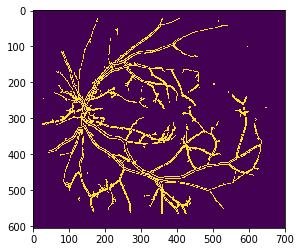

In [7]:
plt.imshow(preprocess_train(X_IMG_PATH + filenames[0]))

In [8]:
def apply_mask_with_color(img, mask):
    img = img.copy()
    img[mask] = MASK_COLOR_RGB
    return img

In [9]:
y_preds, y_trues = [], []
for fname in filenames:
    y_pred = preprocess_train(X_IMG_PATH + fname)
    y_true = preprocess_test(Y_IMG_PATH + fname)
    
    scores = Metrics(y_true.ravel(), y_pred.ravel())
    print(fname, scores)
    
    y_preds.append(y_pred)
    y_trues.append(y_true)

im0162.ppm Acc: 0.91750, sensitivity: 0.50199, specificity: 0.94939, F1-score: 0.46446
im0139.ppm Acc: 0.91843, sensitivity: 0.12224, specificity: 0.98806, F1-score: 0.19422
im0235.ppm Acc: 0.91081, sensitivity: 0.25676, specificity: 0.97472, F1-score: 0.33885
im0255.ppm Acc: 0.91090, sensitivity: 0.49716, specificity: 0.95157, F1-score: 0.49969
im0004.ppm Acc: 0.92574, sensitivity: 0.00022, specificity: 0.99985, F1-score: 0.00044
im0044.ppm Acc: 0.91242, sensitivity: 0.31720, specificity: 0.95698, F1-score: 0.33533
im0001.ppm Acc: 0.90242, sensitivity: 0.03829, specificity: 0.97736, F1-score: 0.05893
im0081.ppm Acc: 0.91724, sensitivity: 0.26405, specificity: 0.96993, F1-score: 0.32265
im0163.ppm Acc: 0.92251, sensitivity: 0.43596, specificity: 0.96329, F1-score: 0.46529
im0291.ppm Acc: 0.95238, sensitivity: 0.18475, specificity: 0.99327, F1-score: 0.28181
im0082.ppm Acc: 0.91379, sensitivity: 0.41732, specificity: 0.95617, F1-score: 0.43230
im0240.ppm Acc: 0.89694, sensitivity: 0.014

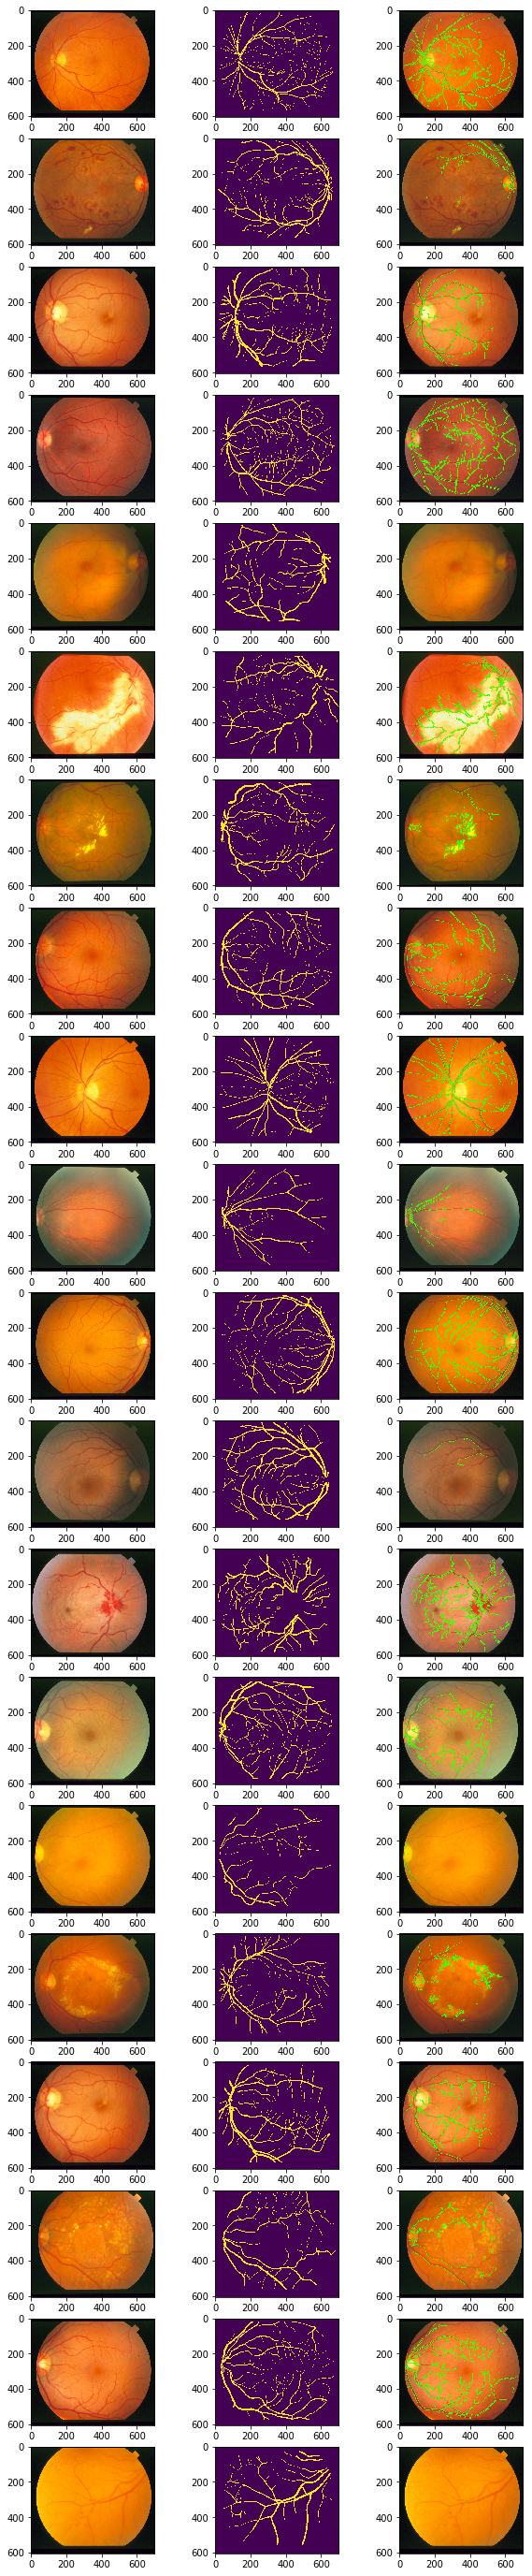

In [24]:
fig = plt.figure(figsize=(10, 50))
cols, rows = 3, len(filenames)

for i in range(rows):
    fig.add_subplot(rows, cols, cols*i + 1)
    plt.imshow(images_orig[i], aspect='equal')
    
    fig.add_subplot(rows, cols, cols*i + 2)
    plt.imshow(y_trues[i], aspect='equal')
    
    fig.add_subplot(rows, cols, cols*i + 3)
    y_pred_mask = apply_mask_with_color(images_orig[i], y_preds[i])
    plt.imshow(y_pred_mask, aspect='equal')
